# Genetic Variant Classifications
---

## Introduction

The ClinVar dataset is a public resource containing annotations about human genetic variants. These variants are (usually manually) classified by clinical laboratories on a categorical spectrum ranging from benign, likely benign, uncertain significance, likely pathogenic, and pathogenic. Variants that have conflicting classifications (from laboratory to laboratory) can cause confusion when clinicians or researchers try to interpret whether the variant has an impact on the disease of a given patient.

Conflicting classifications are when two of any of the following three categories are present for one variant, two submissions of one category are not considered conflicting.

* Likely Benign or Benign
* VUS (uncertain significance)
* Likely Pathogenic or Pathogenic

## Question

Given a set of variant features, we are going to try and identify whether that variant is likely to posses a conflicting classification or not using machine learning as opposed to manual classification.

Conflicting classification has been assigned to a CLASS column. It is a binary representation of whether or not a variant has conflicting classifications, where 0 represents consistent classifications and 1 represents conflicting classifications.

## Models

The machine learning models I will be experiementing with to solve this problem are listed below:

* Logistic Regression
* Random Forest
* Gradient Boosting

In [487]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import EasyEnsemble
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import chi2
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2 as chi2_sk
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
import scipy.stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
%matplotlib inline

## Import the dataset

In [488]:
df = pd.read_csv('./data/clinvar_conflicting.csv')
df.shape

/Users/rook/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(65188, 46)

In [489]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,11.390,1.133255,-2.0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,8.150,0.599088,NaN
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,3.288,0.069819,1.0
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,12.560,1.356499,NaN
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,17.740,2.234711,NaN


### Binary class split

In [490]:
df['CLASS'].value_counts()

0    48754
1    16434
Name: CLASS, dtype: int64

### Data preprocessing

In [491]:
X = df.loc[:, ~df.columns.isin(['CLASS'])]
Y = df['CLASS']

In [501]:
# Converting to categorical
convert_cat = []
to_drop = []
unique = None

categorical = X.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    unique = column.nunique()
    print(unique)
    
    cont = pd.crosstab(X[i], Y)
    chi2_res = scipy.stats.chi2_contingency(cont)
    
    # Keep all features with a significant P-value and drop the others
    if chi2_res[1] <= 0.05:
        convert_cat.append(i)
    else:
        to_drop.append(i)

CHROM
25
REF
866
ALT
458
CLNDISDB
9234
CLNDISDBINCL
48
CLNDN
9260
CLNDNINCL
54
CLNHGVS
65188
CLNSIGINCL
68
CLNVC
7
CLNVI
26289
MC
89
Allele
374
Consequence
48
IMPACT
4
SYMBOL
2328
Feature_type
2
Feature
2369
BIOTYPE
2
EXON
3264
INTRON
1929
cDNA_position
13970
CDS_position
13663
Protein_position
7339
Amino_acids
1262
Codons
2220
BAM_EDIT
2
SIFT
4
PolyPhen
4
MOTIF_NAME
2
HIGH_INF_POS
1


In [500]:
print(f'convert_cat\n------\n{convert_cat} \n')
print(f'to_drop\n------\n{to_drop}')

convert_cat
------
['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNVC', 'MC', 'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature', 'EXON', 'INTRON', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 'BAM_EDIT'] 

to_drop
------
['CLNDISDBINCL', 'CLNDNINCL', 'CLNHGVS', 'CLNSIGINCL', 'CLNVI', 'Feature_type', 'BIOTYPE', 'SIFT', 'PolyPhen', 'MOTIF_NAME', 'HIGH_INF_POS']


### Drop all features with more than 85% NaN's

In [502]:
to_drop_nans = []

for c in X.columns:
    if X[c].isnull().sum() / X.shape[0] > 0.50:
        print(f'{c}: {X[c].isnull().sum() / X.shape[0]}')
        to_drop_nans.append(c)
        
        # Remove from the convert_cat array
        if c in convert_cat:
            convert_cat.remove(c)

CLNDISDBINCL: 0.9988341412529913
CLNDNINCL: 0.9988341412529913
CLNSIGINCL: 0.9988341412529913
CLNVI: 0.5757041173222065
SSR: 0.9984046143461986
INTRON: 0.8649598085537216
DISTANCE: 0.998343253359514
BAM_EDIT: 0.509587654169479
SIFT: 0.6190096336749095
PolyPhen: 0.6196232435417561
MOTIF_NAME: 0.9999693195066577
MOTIF_POS: 0.9999693195066577
HIGH_INF_POS: 0.9999693195066577
MOTIF_SCORE_CHANGE: 0.9999693195066577
BLOSUM62: 0.6073970669448365


In [505]:
X = X.loc[:, ~X.columns.isin(to_drop_nans)]

There were a few features that were almost entirely made up of NaN values.  Instead of imputing this data and essentially creating 60,000+ rows of made up figures, I decided to drop them all together.

In [504]:
convert_cat

['CHROM',
 'REF',
 'ALT',
 'CLNDISDB',
 'CLNDN',
 'CLNVC',
 'MC',
 'Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Feature',
 'EXON',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons']

Above are the remaining categorical features to be converted to binary form.

### Convert features to categorical - get_dummies

In [506]:
# Deleting duplicate rows
X = X.loc[:,~X.columns.duplicated()]

# Drop cols with too many unique values
X = X.loc[:, ~X.columns.isin(to_drop)]

# Get dummies - conver to categroical
X = pd.get_dummies(data=X, columns=convert_cat)

X = X.loc[:,~X.columns.duplicated()]

In [507]:
X.shape

(65188, 66789)

In [ ]:
# Find all features created by get_dummies
cat_feat = []

for feature in convert_cat:
    for col in X.loc[:, X.columns.str.startswith(feature + "_")].columns:
        cat_feat.append(col)

### Run Chi2 after get_dummies

In [544]:
gd_convert_cat = []
gd_to_dropt = []

for feature in cat_feat:
    cont = pd.crosstab(X[feature], Y)
    chi2_res = scipy.stats.chi2_contingency(cont)
    
    # Keep all features with a significant P-value and drop the others
    if chi2_res[1] <= 0.05:
        gd_convert_cat.append(feature)
    else:
        gd_to_dropt.append(feature)

In [545]:
len(gd_to_dropt)

64912

We can see that the results of the Chi2 test are show that we should drop a substntial number of dummy features.

In [546]:
X = X.loc[:, ~X.columns.isin(gd_to_dropt)]

In [547]:
X.shape

(65188, 1876)

Above we can see the number of remaining features by examining the shape of X.

### Finding all NaN rows

In [549]:
nans = lambda X: X[X.isnull().any(axis=1)]
len(nans(X))

10940

There are still quite a few rows with NaN values.  We will have to impute the numerical features.

### Numerical Imputer

In [553]:
numerical_data = X.loc[:, ~X.columns.isin(X[cat_feat])]
print(numerical_data.columns)

Index(['POS', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'ORIGIN', 'STRAND', 'LoFtool',
       'CADD_PHRED', 'CADD_RAW'],
      dtype='object')


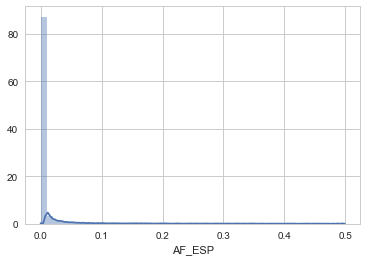

In [554]:
sns.distplot(X['AF_ESP'])

We can see that these numerical features are not normally distributed.  So we will use the median to impute the data. 

In [557]:
# For numerical data, impute using mean OR median values
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp = imp.fit(numerical_data)

# Impute our data
X[numerical_data.columns] = imp.transform(numerical_data)

In [558]:
nans = lambda X: X[X.isnull().any(axis=1)]
len(nans(X))

0

We can see that we no longer have any NaN values in our data.

We do not need to impute the categorical features because get_dummies does this for us.

### VarianceThreshold

In [562]:
# Removes all low-variance features
def variance_threshold_selector(data, threshold=0.95):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

vt_to_drop = variance_threshold_selector(X)

vt_to_drop.head()

,POS,ORIGIN,STRAND,CADD_PHRED,CADD_RAW
0,955563.0,1.0,1.0,11.390,1.133255
1,955597.0,1.0,1.0,8.150,0.599088
2,955619.0,1.0,1.0,3.288,0.069819
3,957640.0,1.0,1.0,12.560,1.356499
4,976059.0,1.0,1.0,17.740,2.234711


In [563]:
X = X.loc[:, ~X.columns.isin(vt_to_drop)]

Variables with low variance really aren’t beneficial to our model.

### Display correlation Matrix to identify features that need to be dropped

In [564]:
correlation_matrix = X.corr()
display(correlation_matrix)

,AF_ESP,AF_EXAC,AF_TGP,LoFtool,CHROM_1,CHROM_2,CHROM_5,CHROM_7,CHROM_10,CHROM_11,...,Codons_tCt/tGt,Codons_tGg/tAg,Codons_tTa/tGa,Codons_taC/taA,Codons_taC/taG,Codons_taT/taA,Codons_tcG/tcA,Codons_tgC/tgA,Codons_tgG/tgA,Codons_ttC/ttT
AF_ESP,1.000000,0.851870,0.807741,0.024530,0.023263,-0.021822,0.006211,0.001599,0.011395,-0.022898,...,-0.007952,-0.008781,-0.004284,-0.007166,-0.006793,-0.004711,0.004803,-0.006221,-0.008826,0.009074
AF_EXAC,0.851870,1.000000,0.805634,0.023114,0.016571,-0.018818,-0.001123,0.003508,0.014726,-0.020768,...,-0.007627,-0.008528,-0.004155,-0.006839,-0.006537,-0.004571,0.005235,-0.006065,-0.008504,0.005833
AF_TGP,0.807741,0.805634,1.000000,0.025189,0.018733,-0.023872,0.005495,0.001747,0.019362,-0.022115,...,-0.008289,-0.008683,-0.004378,-0.007121,-0.006902,-0.004817,0.005580,-0.006394,-0.008986,0.006200
LoFtool,0.024530,0.023114,0.025189,1.000000,-0.042282,0.186457,0.015560,-0.041412,-0.009614,0.121785,...,0.002127,-0.002202,0.005689,-0.000901,0.000648,0.001360,-0.002478,-0.010072,-0.002022,-0.004718
CHROM_1,0.023263,0.016571,0.018733,-0.042282,1.000000,-0.105889,-0.065886,-0.058084,-0.052266,-0.076743,...,-0.004973,0.002776,-0.001062,-0.005684,-0.002868,0.001387,-0.004161,-0.004369,0.000804,0.004612
CHROM_2,-0.021822,-0.018818,-0.023872,0.186457,-0.105889,1.000000,-0.095132,-0.083867,-0.075466,-0.110809,...,0.007609,-0.003856,-0.001377,-0.001826,0.001058,0.004696,-0.010003,-0.002593,-0.006088,-0.002884
CHROM_5,0.006211,-0.001123,0.005495,0.015560,-0.065886,-0.095132,1.000000,-0.052183,-0.046956,-0.068947,...,0.014881,-0.002030,0.003671,-0.002363,0.000782,-0.001015,-0.004765,-0.003440,-0.006686,-0.006659
CHROM_7,0.001599,0.003508,0.001747,-0.041412,-0.058084,-0.083867,-0.052183,1.000000,-0.041396,-0.060782,...,0.000543,-0.002085,0.000720,-0.003575,-0.003064,-0.004030,0.007930,-0.005381,-0.005442,0.007095
CHROM_10,0.011395,0.014726,0.019362,-0.009614,-0.052266,-0.075466,-0.046956,-0.041396,1.000000,-0.054694,...,-0.007826,-0.005060,-0.003295,-0.002691,-0.002200,0.000764,0.003458,-0.001553,-0.004467,-0.000402
CHROM_11,-0.022898,-0.020768,-0.022115,0.121785,-0.076743,-0.110809,-0.068947,-0.060782,-0.054694,1.000000,...,0.001511,0.015828,0.012290,0.004036,0.009554,-0.002210,-0.005767,0.002221,0.011584,-0.001269


In [567]:
# Correlated features to be dropped
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(f'Number of correlated features to drop: {len(to_drop)}')

Number of correlated features to drop: 664


In [568]:
cols = list(X.columns)

for col in to_drop: 
    cols.remove(col)

len(cols)

X = X[cols]

Here we are dropping highly correlated features.

In [586]:
# Save the DF for future reference
X.to_csv('./data/X_df.csv')

## Train / Test splits

In [571]:
# Train splits
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.40, random_state=42, stratify=Y)

# Dev and Test splits
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

We are splitting the data into a train, test and dev set.

## Logistic Regression

In [572]:
lr = LogisticRegression()
lr_fit = lr.fit(X_train, y_train)

# Cross validation
scores_log_r = cross_val_score(lr, X_train, y_train, cv=5)

print(f'Average: {np.round(np.mean(scores_log_r), 4)} (+/- {np.round(scores_log_r.std()*2, 5)})')

Average: 0.7687 (+/- 0.0056)


## Logistic Regression Grid Search

In [573]:
lr_gs = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

grid_log_r = GridSearchCV(lr_gs, param_grid=hyperparameters, cv=5, n_jobs=-1)
grid_log_r.fit(X_train, y_train)

print('Best Score:', grid_log_r.best_score_)

# Best parameters from the grid search
best_params = grid_log_r.best_params_
print('Best Parameters:', best_params)

Best Score: 0.7733176518715483
Best Parameters: {'C': 21.544346900318832, 'penalty': 'l1'}


In [574]:
# Create a model with the best params
lr_2 = LogisticRegression(**best_params)

# Fit the model
lr_2_fit = lr_2.fit(X_train, y_train)

print('Train Accuracy')
print(lr_2_fit.score(X_train, y_train))

print('Dev Accuracy')
print(lr_2_fit.score(X_dev, y_dev))

Train Accuracy
0.7919308652076089
Dev Accuracy
0.775272281024697


## Random Forest

In [575]:
rfc = ensemble.RandomForestClassifier(n_estimators=200, n_jobs=-1)

## Evaluation

In [578]:
# Cross validation
rf_acc = cross_val_score(rfc, X_train, y_train, cv=5, n_jobs=-1)

print(f'Cross Val: {rf_acc}')
print(f'Average: {np.round(np.mean(rf_acc), 4)} (+/- {np.round(rf_acc.std()*2, 5)})')

Cross Val: [0.76722485 0.77566151 0.78061877 0.77588852 0.77103043]
Average: 0.7741 (+/- 0.00916)


## Random Forest Grid Search

In [580]:
parameters = {'n_estimators':[100,300,500],
             'max_features':['sqrt', 'log2'],
             'min_samples_split':[2,8,20],
             'max_depth':[5,6,7,8]}

# Instantiating and fitting Grid Search, then printing best score and best parameters
grid_rfc = GridSearchCV(rfc, param_grid=parameters, cv=5, n_jobs=2)
grid_rfc.fit(X_train, y_train)

print('Best Score:', grid_rfc.best_score_)
best_params_rfc = grid_rfc.best_params_
print('Best Parameters:', best_params_rfc)

Best Score: 0.7479034567396196
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


In [581]:
rfc_2 = ensemble.RandomForestClassifier(**best_params_rfc, n_jobs=-1)
# Fit the model
rfc_2.fit(X_train, y_train)

# Train accuracy
print(f'Train Score: {np.round(rfc.score(X_train, y_train), 4)}')
# Dev accuracy
print(f'Dev Score: {np.round(rfc.score(X_dev, y_dev), 4)}')

Train Score: 0.9912
Dev Score: 0.7711


The Random Forest model and the Logistic Regression model are very similar in their accuracy results.

## Gradient Boosting

In [582]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 700,
          'max_depth': 3,
          'loss': 'deviance'}

# Initialize and fit the model.
gb_clf = ensemble.GradientBoostingClassifier(**params)
gb_acc = cross_val_score(gb_clf, X_train, y_train, cv=5, n_jobs=-1)

print(gb_acc)
print(f'Average: {np.round(np.mean(gb_acc), 4)} (+/- {np.round(gb_acc.std()*2, 5)})')

[0.76671354 0.77540585 0.77000767 0.77358732 0.77435439]
Average: 0.772 (+/- 0.00642)


Gradient Boosting seems to perform slightly better than the Random Forest model

## Gradient Boosting Grid Search

In [583]:
parameters = {
            'loss':['deviance', 'exponential'],
            'min_samples_split':[2, 5, 10],
            'max_depth':[5,6,7,8],
            'max_features':['sqrt', 'log2'],
            'n_estimators':[100,300,600]}

#fitting model and printing best parameters and score from model
grid_gb = GridSearchCV(gb_clf, param_grid=parameters, n_jobs=2)
grid_gb.fit(X_train, y_train)

print('Best Score:', grid_gb.best_score_)
best_params_gb = grid_gb.best_params_
print('Best Parameters:', best_params_gb)

Best Score: 0.7810390672939251
Best Parameters: {'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 600}


In [585]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 600}

# Initialize and fit the model.
gb_clf_2 = ensemble.GradientBoostingClassifier(**params)
gb_clf_2.fit(X_train, y_train)

print(f'Train Score: {gb_clf_2.score(X_train, y_train)}')
print(f'Dev Score: {gb_clf_2.score(X_dev, y_dev)}')
print(f'Test Score: {gb_clf_2.score(X_test, y_test)}')

Train Score: 0.8279556146451217
Dev Score: 0.784706243288848
Test Score: 0.7874674029759166


Gradient Boosting is the most accurate models and seems to be much better in regards generalization.

## Conclusion

While achieving an accuracy level of 78% using Gradient Boosting is not immediately impressive, I think applying machine learning to the field of genomics is a step in the right direction.  While I have no domain knowledge in this specific area, I imagine it would be beneficial to be able to predict with 77% accuracy, wether or not a genetic variation will result in conflicting classifications.  Given this additional knowledge, labs or clinicians could add additional levels of inspection to overcome the increased likelihood of a conflicting classification.

## Challenges I faced

The most challenging aspect of this problem was preprocessing the data.  

* There were quite a few categorical variables that needed to be converted to a binary form.  

* Some of the categorical variables also consisted of thousands of unique values.  

* Every row consisted of NaN values, which meant imputing the data was a necessity.

* I had no domain knowledge in the area, so feature engineering was not an option, which likely hindered my ability to improve the accuracy of my models